In [1]:
import matplotlib.pyplot as plt
import sys

sys.stderr = sys.__stderr__
sys.path.append('/usr/local/lib/python3.7/site-packages/')
plt.rc('font', size=16)

<div>
    <div style="float: left; width: 25%; padding: 2%">
        <img style="float: right" src=https://raw.githubusercontent.com/rusty1s/pytorch_geometric/master/docs/source/_static/img/pyg_logo.svg>
    </div>
    <div style="float: left; width: 75%; padding-left: 2%">
        <h1>PyTorch-Geometric Tutorial</h1>
        <hr style="height: 1.5px">
        <h4 style="line-height: 1.25; margin-top: 25pt">
            Francesco Landolfi<br>Università di Pisa
        </h4>
    <div>
</div>

# Outline #

 1. Introduction
 2. Sparse Data & Indexing in PyTorch
 3. Framework Overview
 4. Machine Learning with PyG
 5. Conclusions

# The "What"
<!-- <figure style="float: right; width: 200pt; padding-right: 2%">
<img src="https://avatars1.githubusercontent.com/u/6945922?s=400&u=d399e6faf2d800e967341d225ec5174db6af7abd&v=4">
    <figcaption align=center><i>Matthias Fey (@rusty1s)</i></figcaption>
</figure> -->

 - Python library for *Geometric Deep Learning* 
 - Written on top of PyTorch
 - Provides utilities for sparse data
 - CUDA/C++ routines for max performance
 
<!-- - Written (mostly) by this guy $\rightarrow$ -->
 

# The "Why"

 - A must-have if you are a (G)DL guy
 - Only few more alternatives:
   - Deep Graph Library (DGL, PyTorch)
   - Stellar Graph, Euler (TF)
   - Other wannabes (<1K stars on GitHub)
 - Many ready-to-use models and datasets
 - Good for any Data-Parallel algorithm on graph

# The "When"

 You have an algorithm on graphs/meshes/point clouds and
 - you want to execute it on multiple samples in parallel
 - you want to exploit SIMD/GPU resources
 - you are able to **remodel** your algorithm as 
  - a composition of simple algebraic operations, or 
  - a *message-passing* model
 
**Spoiler:** Some algorithms are not easily remodelable!

# The "How"

You need (of course) Python, PyTorch 1.7 and a few more libraries: 
```sh
export TORCH=1.7.0
export CUDA=cu101  # or 'cpu', 'cu102', 'cu101', 'cu100', 'cu92'
pip install --no-index torch-scatter torch-sparse torch-cluster \\
    -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
pip install torch-geometric
```
Full docs here: https://pytorch-geometric.readthedocs.io/en/latest/ 

**Note:** To execute this notebook you will also need `networkx`, `matplotlib`, `trimesh`, `pandas`, `rdkit`, and `skorch`

In [2]:
import torch; print(torch.__version__)

1.7.0+cu101


In [3]:
%%bash
# Copy the values above!
export TORCH=1.7.0
export CUDA=cu101

pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
pip install torch-geometric skorch trimesh

Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
  Created wheel for torch-geometric: filename=torch_geometric-1.6.3-cp36-none-any.whl size=322720 sha256=be3a4c654b5820e8a05177a96c5dc8cd142e6d193b188b62e90249f5b1301499
  Stored in directory: /root/.cache/pip/wheels/6d/47/1e/0af8ce3e21783c3e584c22502011a3367c091694eebc50a971
Successfully built torch-geometric


In [4]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda config --set always_yes yes --set changeps1 no
!conda install -q -y -c conda-forge python=3.7
!conda install -q -y -c conda-forge rdkit==2020.09.2 

--2021-02-07 09:59:53--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2021-02-07 09:59:53--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94235922 (90M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  89.87M   218MB/s    in 0.4s    

2021-02-07 09:59:54 (218 MB/s) - ‘Miniconda3-latest-Linux

# Dense v. Sparse

**Example:** Storing graph edges

 - As matrix *(dense)* $\implies O(|V|^2)$ 
 - As indices *(sparse)* $\implies O(|E|) \le O(|V|^2)$ 

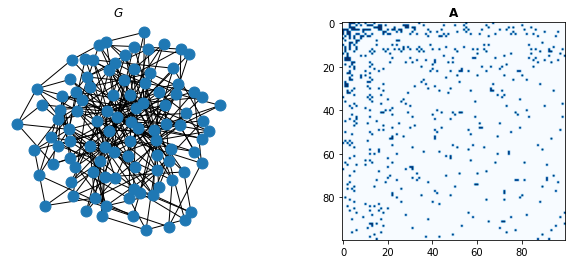

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.barabasi_albert_graph(100, 3)
_, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'wspace': 0.5})
nx.draw_kamada_kawai(G, ax=axes[0], node_size=120)
axes[1].imshow(nx.to_numpy_matrix(G), aspect='auto', cmap='Blues')
axes[0].set_title("$G$")
axes[1].set_title("$\mathbf{A}$")
plt.show()

# Sparse Representations #

We store a feature matrix $\mathbf{X} \in \mathbb{R}^{n\times h}$, then

 - **Edges:** a matrix of indices $\mathbf{E} \in \mathbb{N}^{2\times m}$
 - **Triangles:** a matrix of indices $\mathbf{T} \in \mathbb{N}^{3\times t}$
 - **Attributes:** feature matrices $\mathbf{W}_E \in \mathbb{R}^{m\times h_E}$ and/or  $\mathbf{W}_T \in \mathbb{R}^{t\times h_T}$,

# Indexing/Slicing in PyTorch#

Basically `tensor[idx, ...]` and `tensor[start:end:stride, ...]`

In [6]:
import torch

mat = torch.arange(12).view(3, 4)
mat

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

In [7]:
mat[0]

tensor([0, 1, 2, 3])

In [8]:
mat[:, -1]

tensor([ 3,  7, 11])

In [9]:
mat[:, 2:]

tensor([[ 2,  3],
        [ 6,  7],
        [10, 11]])

In [10]:
mat[:, ::2]

tensor([[ 0,  2],
        [ 4,  6],
        [ 8, 10]])

not only *R-values*...

In [11]:
mat[:, ::2] = 42
mat

tensor([[42,  1, 42,  3],
        [42,  5, 42,  7],
        [42,  9, 42, 11]])

In [12]:
mat[:, 1::2] = -mat[:, ::2]
mat

tensor([[ 42, -42,  42, -42],
        [ 42, -42,  42, -42],
        [ 42, -42,  42, -42]])

In [13]:
mat[1::2] = -mat[::2]
mat

RuntimeError: ignored

In [14]:
mat[1, :, :] = 0
mat

IndexError: ignored

In [15]:
mat[1, ..., 2] = 5
mat

tensor([[ 42, -42,  42, -42],
        [ 42, -42,   5, -42],
        [ 42, -42,  42, -42]])

# Masked Selection

Using a `BoolTensor` to select values inside another `Tensor`

In [16]:
rnd = torch.rand(3, 9)
rnd

tensor([[0.2734, 0.5364, 0.5117, 0.3025, 0.9657, 0.7272, 0.4525, 0.0466, 0.1295],
        [0.6661, 0.2012, 0.7298, 0.3882, 0.0925, 0.3736, 0.9045, 0.8685, 0.7653],
        [0.2312, 0.9608, 0.5847, 0.2465, 0.8775, 0.4408, 0.4716, 0.2921, 0.2519]])

In [17]:
mask = rnd >= 0.5
mask

tensor([[False,  True,  True, False,  True,  True, False, False, False],
        [ True, False,  True, False, False, False,  True,  True,  True],
        [False,  True,  True, False,  True, False, False, False, False]])

In [18]:
mask.type()

'torch.BoolTensor'

In [19]:
rnd[mask]

tensor([0.5364, 0.5117, 0.9657, 0.7272, 0.6661, 0.7298, 0.9045, 0.8685, 0.7653,
        0.9608, 0.5847, 0.8775])

**Note:** Masking returns *always* a 1-D tensor!

In [20]:
rnd[:, (~mask).all(0)]

tensor([[0.3025],
        [0.3882],
        [0.2465]])

In [21]:
rnd[mask] = 0
rnd

tensor([[0.2734, 0.0000, 0.0000, 0.3025, 0.0000, 0.0000, 0.4525, 0.0466, 0.1295],
        [0.0000, 0.2012, 0.0000, 0.3882, 0.0925, 0.3736, 0.0000, 0.0000, 0.0000],
        [0.2312, 0.0000, 0.0000, 0.2465, 0.0000, 0.4408, 0.4716, 0.2921, 0.2519]])

# Index selection

Using a `LongTensor` to select values at specific indices

In [22]:
A = torch.randint(2, (5, 5))
A

tensor([[0, 1, 1, 0, 0],
        [0, 0, 1, 0, 1],
        [1, 0, 1, 0, 1],
        [0, 1, 1, 0, 1],
        [1, 1, 0, 0, 0]])

In [23]:
idx = A.nonzero().T
idx

tensor([[0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4],
        [1, 2, 2, 4, 0, 2, 4, 1, 2, 4, 0, 1]])

In [24]:
A[idx]

tensor([[[0, 1, 1, 0, 0],
         [0, 1, 1, 0, 0],
         [0, 0, 1, 0, 1],
         [0, 0, 1, 0, 1],
         [1, 0, 1, 0, 1],
         [1, 0, 1, 0, 1],
         [1, 0, 1, 0, 1],
         [0, 1, 1, 0, 1],
         [0, 1, 1, 0, 1],
         [0, 1, 1, 0, 1],
         [1, 1, 0, 0, 0],
         [1, 1, 0, 0, 0]],

        [[0, 0, 1, 0, 1],
         [1, 0, 1, 0, 1],
         [1, 0, 1, 0, 1],
         [1, 1, 0, 0, 0],
         [0, 1, 1, 0, 0],
         [1, 0, 1, 0, 1],
         [1, 1, 0, 0, 0],
         [0, 0, 1, 0, 1],
         [1, 0, 1, 0, 1],
         [1, 1, 0, 0, 0],
         [0, 1, 1, 0, 0],
         [0, 0, 1, 0, 1]]])

In [25]:
row, col = idx  # row, col = idx[0], idx[1]
A[row, col]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [26]:
weight = torch.randint(10, (idx.size(1),))
weight

tensor([0, 7, 4, 3, 5, 4, 4, 4, 0, 2, 6, 7])

In [27]:
A[row, col] = weight
A

tensor([[0, 0, 7, 0, 0],
        [0, 0, 4, 0, 3],
        [5, 0, 4, 0, 4],
        [0, 4, 0, 0, 2],
        [6, 7, 0, 0, 0]])

In [28]:
w, perm = torch.sort(weight)
w, idx[:, perm] 

(tensor([0, 0, 2, 3, 4, 4, 4, 4, 5, 6, 7, 7]),
 tensor([[0, 3, 3, 1, 1, 2, 2, 3, 2, 4, 0, 4],
         [1, 2, 4, 4, 2, 2, 4, 1, 0, 0, 2, 1]]))

# Gathering

In [29]:
rnd = torch.randint(10, (3, 9))
rnd

tensor([[2, 5, 7, 3, 0, 5, 2, 2, 6],
        [4, 4, 2, 9, 2, 9, 9, 0, 4],
        [3, 4, 9, 3, 1, 8, 1, 6, 0]])

In [30]:
sort, perm = torch.sort(rnd, dim=-1)
sort, perm

(tensor([[0, 2, 2, 2, 3, 5, 5, 6, 7],
         [0, 2, 2, 4, 4, 4, 9, 9, 9],
         [0, 1, 1, 3, 3, 4, 6, 8, 9]]), tensor([[4, 0, 6, 7, 3, 1, 5, 8, 2],
         [7, 2, 4, 0, 1, 8, 3, 5, 6],
         [8, 4, 6, 0, 3, 1, 7, 5, 2]]))

In [31]:
torch.gather(input=rnd, dim=-1, index=perm)

tensor([[0, 2, 2, 2, 3, 5, 5, 6, 7],
        [0, 2, 2, 4, 4, 4, 9, 9, 9],
        [0, 1, 1, 3, 3, 4, 6, 8, 9]])

`input` and `index` *must have the same shape*, except along `dim`!

**Example:** Top-$k$ elements of each row

In [32]:
k = 3
torch.gather(input=rnd, dim=-1, index=perm[:, :k])

tensor([[0, 2, 2],
        [0, 2, 2],
        [0, 1, 1]])

# Scattering

In [33]:
rnd, perm

(tensor([[2, 5, 7, 3, 0, 5, 2, 2, 6],
         [4, 4, 2, 9, 2, 9, 9, 0, 4],
         [3, 4, 9, 3, 1, 8, 1, 6, 0]]), tensor([[4, 0, 6, 7, 3, 1, 5, 8, 2],
         [7, 2, 4, 0, 1, 8, 3, 5, 6],
         [8, 4, 6, 0, 3, 1, 7, 5, 2]]))

In [34]:
torch.scatter(input=rnd, dim=-1, index=perm[:, :k], src=-torch.ones_like(rnd))

tensor([[-1,  5,  7,  3, -1,  5, -1,  2,  6],
        [ 4,  4, -1,  9, -1,  9,  9, -1,  4],
        [ 3,  4,  9,  3, -1,  8, -1,  6, -1]])

What if we assign multiple values to the same index?

In [35]:
row, col

(tensor([0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4]),
 tensor([1, 2, 2, 4, 0, 2, 4, 1, 2, 4, 0, 1]))

In [36]:
x = torch.arange(A.size(0))
torch.scatter(input=x, dim=-1, index=col, src=row)

tensor([4, 4, 3, 3, 3])

Use `torch_scatter` to perform aggregations

In [37]:
import torch_scatter

torch_scatter.scatter_min(src=row, index=col, dim=-1)
# torch_scatter.scatter_max(src=row, index=col, dim=-1)
# torch_scatter.scatter_add(src=row, index=col, dim=-1)
# torch_scatter.scatter_mean(src=row, index=col, dim=-1)
# torch_scatter.scatter_mul(src=row, index=col, dim=-1)

(tensor([2, 0, 0, 0, 1]), tensor([ 4,  0,  1, 12,  3]))

# Framework Overview

PyTorch-Geometric sub-modules:

 - `nn`: contains (lots of) GNN models, pooling, normalizations
 - `data`: classes for managing sparse and dense data
 - `datasets`: basically every standard benchmark dataset for graphs, meshes, and point clouds, with different kinds of tasks
 - `transform`: data manipulation functions
 - `utils` and `io`: utility functions

# `Data` Class

An (extensible) container for a single graph/mesh/whatever. Typical attributes:

 - `x`: node features of size $n\times h_V$
 - `edge_index`: edge indices, of size $2\times m$
 - `edge_attr`: edge attributes, of size $m\times h_E$
 - `face`: triangle node indices, of size $3\times t$
 - `pos`: positions in the Euclidean space, of size $n\times d$
 - `norm`: normal vectors, of size $n\times d$
 - `y`: target of the sample (the size depends on the task)

# Some Examples

You can define it yourself...

In [38]:
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
data

Data(edge_index=[2, 4], x=[3, 1])

<img style="width: 33%; margin-left: 15%" src=http://pytorch-geometric.readthedocs.io/en/latest/_images/graph.svg>

# Some Examples

...or load it from `trimesh`, `networkx`, `scipy`, etc.

In [39]:
!wget -nc https://raw.githubusercontent.com/mikedh/trimesh/master/models/bunny.ply

--2021-02-07 10:03:23--  https://raw.githubusercontent.com/mikedh/trimesh/master/models/bunny.ply
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 658744 (643K) [text/plain]
Saving to: ‘bunny.ply’

bunny.ply           100%[===================>] 643.30K  --.-KB/s    in 0.01s   

2021-02-07 10:03:23 (51.1 MB/s) - ‘bunny.ply’ saved [658744/658744]



In [40]:
import trimesh

m = trimesh.load('bunny.ply')
m.show()

In [41]:
from torch_geometric import utils

data = utils.from_trimesh(m)
data

Data(face=[3, 16301], pos=[8146, 3])

In [42]:
from torch_geometric import transforms

f2e = transforms.FaceToEdge(remove_faces=False)
f2e(data)

Data(edge_index=[2, 48726], face=[3, 16301], pos=[8146, 3])

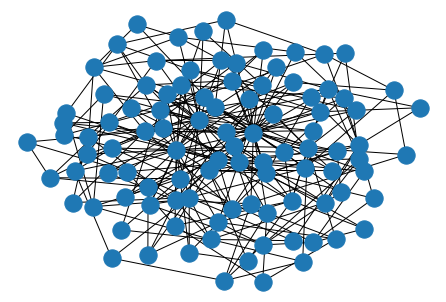

In [43]:
import networkx as nx

G = nx.barabasi_albert_graph(n=100, m=3)
nx.draw_kamada_kawai(G)

In [44]:
data = utils.from_networkx(G)
data

Data(edge_index=[2, 582])

In [45]:
s2d = transforms.ToDense(num_nodes=120)
s2d(data)

Data(adj=[120, 120], mask=[120])

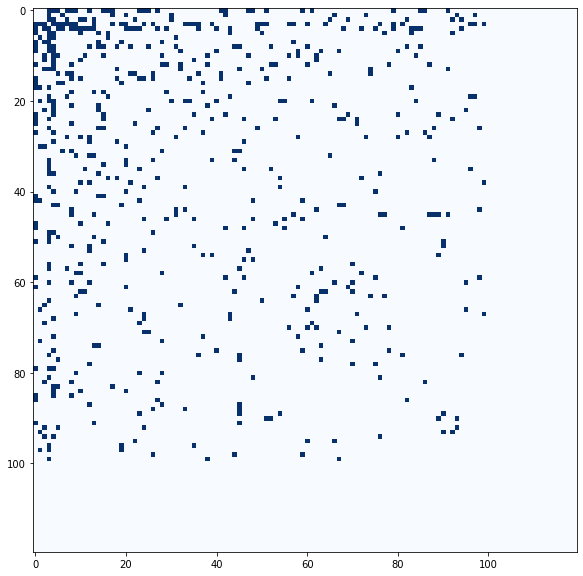

In [46]:
adj = data.adj.numpy()

_, ax = plt.subplots(figsize=(10, 10))
ax.imshow(adj, cmap='Blues')
plt.show()

# Ready-to-use Datasets

Lots of them:

 - Graph tasks: `TUDataset` collection, `Amazon`, `QM9`, ...
 - Mesh tasks: `FAUST` and `DynamicFaust` human poses, `ModelNet`, `SHREC`s, ...
 - Point Clouds tasks: `ShapeNet`, `S3DIS` in-door scenes, `PCPNetDataset`, ...

# Some Examples

In [50]:
from torch_geometric.datasets import TUDataset, TOSCA

ds = TUDataset(root='./data/', name='PROTEINS')
ds

PROTEINS(1113)

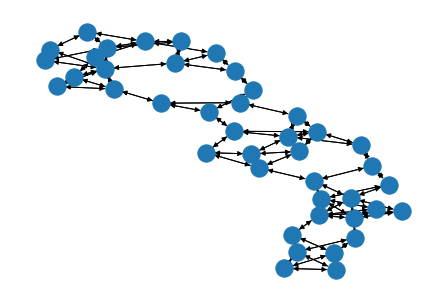

In [51]:
G = utils.to_networkx(ds[0])
nx.draw_kamada_kawai(G)

In [64]:
ds = TOSCA(root="./data/TOSCA/", categories=['Dog'])
ds.data.face -= 1  # Fix TOSCA face indices!

Processing...
Done!


In [65]:
m = utils.to_trimesh(ds[0])
m.show()

# DIY Dataset

You can create your own dataset by extending `InMemoryDataset`:

 - Specify the data you *need* in `raw_file_names()`
 - Specify the data you *generate* in `processed_file_names()`
 - Implement `download()` and `process()`
 - Load your (processed) data in `__init__()`

# Example: COVID dataset

Fragments screened for 3CL protease binding, see https://www.aicures.mit.edu/

In [66]:
from torch_geometric.data import InMemoryDataset, download_url
from rdkit import Chem
import pandas as pd


class COVID(InMemoryDataset):
    url = 'https://github.com/yangkevin2/coronavirus_data/raw/master/data/mpro_xchem.csv'

    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super(COVID, self).__init__(root, transform, pre_transform, pre_filter)
        
        # Load processed data
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['mpro_xchem.csv']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        download_url(self.url, self.raw_dir)

    def process(self):
        df = pd.read_csv(self.raw_paths[0])
        data_list = []

        for smiles, label in df.itertuples(False, None):
            mol = Chem.MolFromSmiles(smiles)  # Read the molecule info
            adj = Chem.GetAdjacencyMatrix(mol)  # Get molecule structure
            
            # You should extract other features here!
            data = Data(num_nodes=adj.shape[0], 
                        edge_index=torch.Tensor(adj).nonzero().T, 
                        y=label)
            
            data_list.append(data)

        self.data, self.slices = self.collate(data_list)
        torch.save((self.data, self.slices), self.processed_paths[0])

In [67]:
covid = COVID(root='./data/COVID/')
covid

Processing...
Done!


COVID(880)

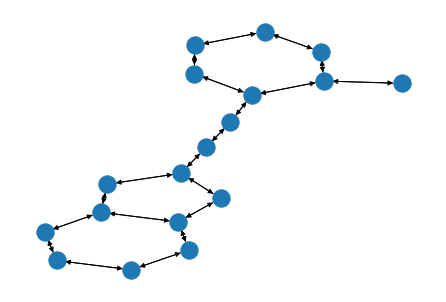

In [68]:
G = utils.to_networkx(covid[0])
nx.draw_kamada_kawai(G)

# Mini-Batches

Processing multiple graphs as a single, disconnected graph

$$
\begin{align*}
\mathbf{A} = \begin{bmatrix} \mathbf{A}_1 & & \\ & \ddots & \\ & & \mathbf{A}_n \end{bmatrix}, \quad &\mathbf{X} = \begin{bmatrix} \mathbf{X}_1 \\ \vdots \\ \mathbf{X}_n \end{bmatrix}, \quad \mathbf{Y} = \begin{bmatrix} \mathbf{Y}_1 \\ \vdots \\ \mathbf{Y}_n \end{bmatrix}  \tag{sparse}\\
\mathbf{A} = \begin{bmatrix} \widehat{\mathbf{A}}_1 \\ \vdots \\ \widehat{\mathbf{A}}_n \end{bmatrix}, \quad &\mathbf{X} = \begin{bmatrix} \mathbf{X}_1 \\ \vdots \\ \mathbf{X}_n \end{bmatrix}, \quad \mathbf{Y} = \begin{bmatrix} \mathbf{Y}_1 \\ \vdots \\ \mathbf{Y}_n \end{bmatrix} \tag{dense}
\end{align*}
$$

# `Batch` Class

A `Data` sub-class, representing a *sparse* batch of graphs

In [69]:
from torch_geometric.data import Batch

b = Batch.from_data_list(covid[:10])
b

Batch(batch=[166], edge_index=[2, 352], y=[10])

In [70]:
b.batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [71]:
b.edge_index[0]

tensor([  0,   1,   1,   1,   2,   2,   3,   3,   4,   4,   5,   5,   6,   6,
          6,   7,   7,   8,   8,   9,   9,   9,  10,  10,  11,  11,  11,  12,
         12,  13,  13,  14,  14,  15,  15,  16,  16,  16,  17,  17,  18,  19,
         19,  19,  20,  21,  21,  22,  22,  23,  23,  24,  24,  24,  25,  25,
         26,  26,  27,  27,  27,  28,  28,  29,  29,  30,  30,  30,  31,  32,
         32,  33,  33,  33,  34,  35,  35,  35,  36,  36,  36,  37,  37,  37,
         38,  38,  38,  39,  39,  40,  40,  41,  41,  42,  42,  43,  43,  44,
         44,  45,  45,  46,  47,  48,  48,  48,  49,  49,  50,  50,  51,  51,
         52,  52,  52,  53,  53,  54,  54,  55,  55,  55,  56,  56,  57,  57,
         57,  58,  58,  58,  58,  59,  60,  61,  62,  63,  63,  63,  64,  65,
         65,  66,  66,  66,  67,  67,  68,  68,  69,  69,  69,  70,  70,  71,
         71,  71,  72,  72,  73,  73,  74,  74,  75,  75,  76,  76,  77,  77,
         78,  78,  79,  80,  80,  80,  81,  82,  82,  82,  83,  

In [72]:
covid[9].edge_index[0]

tensor([ 0,  1,  1,  2,  2,  2,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,  7,  8,
         8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 14, 14, 15, 15, 16, 16])

In [75]:
print(Data.__inc__.__doc__)

Returns the incremental count to cumulatively increase the value
        of the next attribute of :obj:`key` when creating batches.

        .. note::

            This method is for internal use only, and should only be overridden
            if the batch concatenation process is corrupted for a specific data
            attribute.
        


# `MessagePassing` Class

Model a Neural Network (or any algorithm) by defining

 - `message()`: the information "delivered" (by `propagate()`) from *source* to *target* (or viceversa) endnodes of an edge 
   - can use data from both nodes (`x`, `pos`, or user-defined)
   - can use data from the edge itself (`edge_attr`)
 - `aggregate()`: how the messages from the neighbors are aggregated
   - must be *permutation invariant*
   - no need to override if it's just `"add"`, `"mean"`, or `"max"`
 - `update()`: a function applied to the aggregated messages


# Example: Connected Components

Typically done sequentially using Disjoint-Sets, we remodel as MP to exploit parallelism

In [76]:
from torch_geometric.nn import MessagePassing


class ConnectedComponents(MessagePassing):
    def __init__(self):
        super(ConnectedComponents, self).__init__(aggr="max")
        
    def forward(self, data):
        x = torch.arange(data.num_nodes).view(-1, 1)
        last_x = torch.zeros_like(x)
        
        while not x.equal(last_x):
            last_x = x.clone()
            x = self.propagate(data.edge_index, x=x)
            x = torch.max(x, last_x)
        
        unique, perm = torch.unique(x, return_inverse=True)
        perm = perm.view(-1)
        
        if "batch" not in data:
            return unique.size(0), perm
        
        cc_batch = unique.scatter(dim=-1, index=perm, src=data.batch)
        
        return cc_batch.bincount(minlength=data.num_graphs), perm
            
    def message(self, x_j):
        return x_j
    
    def update(self, aggr_out):
        return aggr_out        

In [77]:
ds = TUDataset(root='./data/', name='PROTEINS')
data = Batch.from_data_list(ds[:10])

cc = ConnectedComponents()
count, perm = cc(data)
count

tensor([1, 1, 1, 1, 1, 8, 4, 1, 1, 1])

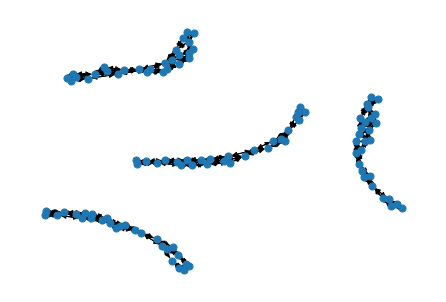

In [78]:
G = utils.to_networkx(ds[6])
nx.draw(G, node_size=50)

# Learning with PyG

Many, many standard GNNs & PointNets in the `nn` submodule

In [79]:
from torch_geometric.nn import GCNConv, JumpingKnowledge, global_add_pool
from torch.nn import functional as F


class SimpleGNN(torch.nn.Module):
    def __init__(self, dataset, hidden=64, layers=6):
        super(SimpleGNN, self).__init__()
        
        self.dataset = dataset
        self.convs = torch.nn.ModuleList()
        
        self.convs.append(GCNConv(in_channels=dataset.num_node_features, 
                                  out_channels=hidden))
        
        for _ in range(1, layers):
            self.convs.append(GCNConv(in_channels=hidden, 
                                      out_channels=hidden))
        
        self.jk = JumpingKnowledge(mode="cat")
        self.jk_lin = torch.nn.Linear(in_features=hidden*layers, 
                                      out_features=hidden)
        
        self.lin_1 = torch.nn.Linear(in_features=hidden, 
                                     out_features=hidden)
        self.lin_2 = torch.nn.Linear(in_features=hidden, 
                                     out_features=dataset.num_classes)
        
    def forward(self, data):
        x = data.x
        xs = []
        
        for conv in self.convs:
            x = F.relu(conv(x=x, edge_index=data.edge_index))
            xs.append(x)
            
        x = self.jk(xs)
        x = F.relu(self.jk_lin(x))
        x = global_add_pool(x, batch=data.batch)
        x = F.relu(self.lin_1(x))
        x = F.softmax(self.lin_2(x), dim=-1)
        
        return x

In [80]:
ohd = transforms.OneHotDegree(max_degree=4)
covid = COVID(root='./data/COVID/', transform=ohd) 
covid[0]

Data(edge_index=[2, 40], x=[18, 5], y=[1])

In [83]:
import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring

from torch_geometric.data import DataLoader


# This function is needed to make Skorch work with Data objects
def _to_tensor_wrapper(func):
    to_tensor = func

    def wrapper(X, device, allow_sparse=False):
        if isinstance(X, Data):
            return X.to(device)

        return to_tensor(X, device, allow_sparse)

    return wrapper


skorch.net.to_tensor = _to_tensor_wrapper(skorch.net.to_tensor)

# This is needed to bypass Skorch's length check 
class SkorchDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y

        self._len = len(X)

    def __len__(self):
        return self._len

    def __getitem__(self, i):
        return self.X[i], self.y[i]


# X must be a list of Data (a Dataset won't work)
X, y = list(covid), covid.data.y

score_name = 'valid_mae'

net = NeuralNetClassifier(
    module=SimpleGNN,
    module__dataset=covid,
    max_epochs=20,
    optimizer=torch.optim.SGD,  # Change this to Adam and see what happens
    batch_size=-1,
    lr=0.001,
    dataset=SkorchDataset,
    iterator_train=DataLoader,
    iterator_valid=DataLoader,
    iterator_train__shuffle=True,
    iterator_valid__shuffle=False,
)

net.get_params()

{'batch_size': -1,
 'callbacks': None,
 'callbacks__epoch_timer': <skorch.callbacks.logging.EpochTimer at 0x7f2f63beac18>,
 'callbacks__print_log': <skorch.callbacks.logging.PrintLog at 0x7f2f63beae48>,
 'callbacks__print_log__floatfmt': '.4f',
 'callbacks__print_log__keys_ignored': None,
 'callbacks__print_log__sink': <function print>,
 'callbacks__print_log__stralign': 'right',
 'callbacks__print_log__tablefmt': 'simple',
 'callbacks__train_loss': <skorch.callbacks.scoring.PassthroughScoring at 0x7f2f63beacf8>,
 'callbacks__train_loss__lower_is_better': True,
 'callbacks__train_loss__name': 'train_loss',
 'callbacks__train_loss__on_train': True,
 'callbacks__valid_acc': <skorch.callbacks.scoring.EpochScoring at 0x7f2f63beadd8>,
 'callbacks__valid_acc__lower_is_better': False,
 'callbacks__valid_acc__name': 'valid_acc',
 'callbacks__valid_acc__on_train': False,
 'callbacks__valid_acc__scoring': 'accuracy',
 'callbacks__valid_acc__target_extractor': <function skorch.utils.to_numpy>,
 '

In [84]:
fit = net.fit(X, y)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6902       0.4148        0.6956  0.3768
      2        0.6849       0.4830        0.6915  0.3888
      3        0.6797       0.5852        0.6875  0.3808
      4        0.6746       0.6023        0.6836  0.3828
      5        0.6696       0.6193        0.6798  0.3974
      6        0.6647       0.7216        0.6759  0.3804
      7        0.6599       0.7500        0.6721  0.4029
      8        0.6551       0.7670        0.6684  0.3999
      9        0.6504       0.8011        0.6647  0.3865
     10        0.6457       0.8352        0.6610  0.4069
     11        0.6411       0.8466        0.6574  0.4037
     12        0.6366       0.8580        0.6538  0.3824
     13        0.6321       0.8636        0.6502  0.3900
     14        0.6276       0.8636        0.6467  0.3808
     15        0.6232       0.8807        0.6432  0.3756
     16        0.6188       0.8

# Conclusion

Pros:
 - Versatile framework
 - 0h spent recreating s.o.t.a. models
 - No need to look for data
 
Cons:
 - Steep learning curve
 - You need to get used to sparse data
 - Sometimes you need to create two models for one task (sparse/dense)

<div style="height: 50%; padding-top: 10%">
<center><h1>Questions?</h1></center>
<div style="margin-top: 20%">
Francesco Landolfi<br>
francesco.landolfi@phd.unipi.it
</div>
</div>